In [1]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import joblib
import torch
import torch.nn as nn
import shap
import matplotlib.pyplot as plt
import warnings
import os

In [2]:
# ----------------------------
# 0) Config
# ----------------------------
CSV_PATH = "battery_feature_extracted.csv"
TARGET_COL = "average_voltage"
MODEL_PATH = "entire_model_transformer_rnn_lstm_mae2747_mse2588_r29012.pth"
SCALER_PATH = "scaler.pkl"    
LOCAL_IDX = 0                  # which test sample to explain locally

np.random.seed(42)

In [4]:
# ----------------------------
# 1) Load data and split
# ----------------------------
dataset = pd.read_csv(CSV_PATH)
X = dataset.drop(columns=[TARGET_COL])
y = dataset[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42
)

num_features = X_train.shape[1]
feature_names = X.columns.tolist()

In [5]:
# ----------------------------
# 2) Define model architecture (must match the one used when saving)
# ----------------------------
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)   # final hidden state
        h_n = h_n[-1]
        out = self.fc(h_n)
        return out

In [6]:
class TabTransformerWithLSTM(nn.Module):
    def __init__(self, num_features, output_size=1, dim_embedding=128,
                 num_heads=2, num_layers=2, lstm_hidden_size=128,
                 lstm_num_layers=1, lstm_dropout=0.5):
        super().__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_embedding, nhead=num_heads, batch_first=True, dropout=0.70
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.lstm_network = LSTMNetwork(
            dim_embedding, lstm_hidden_size, output_size,
            num_layers=lstm_num_layers, dropout=lstm_dropout
        )
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)          # add sequence dimension
        x = self.transformer(x)
        x = self.lstm_network(x)
        return x

In [7]:
# Instantiate the model with the same hyperparameters as training
device = torch.device("cpu")  # SHAP KernelExplainer runs on CPU
model = TabTransformerWithLSTM(
    num_features=num_features,
    output_size=1,
    dim_embedding=128,
    num_heads=2,
    num_layers=2,
    lstm_hidden_size=128,
    lstm_num_layers=1,
    lstm_dropout=0.5
).to(device)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [9]:
# ----------------------------
# 3) Load trained weights
# ----------------------------
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")
state = torch.load(MODEL_PATH, map_location=device)
# Prefer strict=True; if you changed code since training, set strict=False temporarily.
model.load_state_dict(state, strict=True)
model.eval()

C:\Users\Admin\AppData\Local\Temp\ipykernel_24408\2247496982.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=device)


TabTransformerWithLSTM(
  (embedding): Linear(in_features=3226, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.7, inplace=False)
        (dropout2): Dropout(p=0.7, inplace=False)
      )
    )
  )
  (lstm_network): LSTMNetwork(
    (lstm): LSTM(128, 128, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [10]:
# ----------------------------
# 4) Load (or re-fit) the scaler
# ----------------------------
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
else:
    warnings.warn(
        "Could not find scaler.pkl — refitting RobustScaler on current X_train. "
        "For consistent SHAP with the trained model, prefer loading the original scaler."
    )
    scaler = RobustScaler().fit(X_train)

# Scale data (same preprocessing as training)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Tensors + NumPy for SHAP
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor  = torch.FloatTensor(X_test_scaled)
X_train_np     = X_train_tensor.numpy()
X_test_np      = X_test_tensor.numpy()


C:\Users\Admin\AppData\Local\Temp\ipykernel_24408\3745609998.py:7: UserWarning: Could not find scaler.pkl — refitting RobustScaler on current X_train. For consistent SHAP with the trained model, prefer loading the original scaler.
  warnings.warn(


In [11]:
# ----------------------------
# 5) Wrap model for SHAP
# ----------------------------
def wrapped_model(x_numpy: np.ndarray):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32, device=device)
    with torch.no_grad():
        preds = model(x_tensor).cpu().numpy()
    return preds  # shape: (n, 1)

# Background for Kernel SHAP (subset of training)
bg_size = min(BACKGROUND_SIZE, X_train_np.shape[0])
bg_idx = np.random.choice(X_train_np.shape[0], bg_size, replace=False)
background = X_train_np[bg_idx]

explainer = shap.KernelExplainer(wrapped_model, background)


## Local SHAP

### best / median / worst error

In [19]:
# 1) Get predictions on the whole test set
with torch.no_grad():
    x_tensor_all = torch.tensor(X_test_np, dtype=torch.float32, device=device)
    preds_all = model(x_tensor_all).cpu().numpy().reshape(-1)

y_test_values = y_test.values.reshape(-1)
abs_err = np.abs(preds_all - y_test_values)

In [20]:
# 2) Find indices for best (min), worst (max), and median error
best_idx = int(np.argmin(abs_err))
worst_idx = int(np.argmax(abs_err))

# median error index (choose the middle of the sorted-by-error list)
sorted_idx = np.argsort(abs_err)
median_idx = int(sorted_idx[len(sorted_idx) // 2])

triplet = [("Best (min error)", best_idx),
           ("Median (typical error)", median_idx),
           ("Worst (max error)", worst_idx)]

print("Selected samples by absolute error:")
for label, i in triplet:
    print(f" - {label}: idx={i}, pred={preds_all[i]:.4f} V, actual={y_test_values[i]:.4f} V, |err|={abs_err[i]:.4f} V")


Selected samples by absolute error:
 - Best (min error): idx=270, pred=2.4671 V, actual=2.4671 V, |err|=0.0000 V
 - Median (typical error): idx=74, pred=2.9417 V, actual=2.8242 V, |err|=0.1175 V
 - Worst (max error): idx=154, pred=3.2691 V, actual=0.0455 V, |err|=3.2235 V


In [23]:
# 3) Helper to explain and plot a single index
def explain_and_plot_idx(idx, title_prefix=""):
    # Prepare single-sample arrays
    x_scaled_row = X_test_np[[idx]]
    x_orig_row   = X_test.iloc[[idx]].values[0]

    # SHAP values for this sample
    local_shap_vals = explainer.shap_values(x_scaled_row)  # -> (1, n_features) for regression
    expected_value  = explainer.expected_value
    local_shap_vals = np.array(local_shap_vals).reshape(-1)

    # Pack as Explanation so we can use waterfall with original feature values
    local_expl = shap.Explanation(
        values=local_shap_vals,
        base_values=np.array([expected_value]),
        data=x_orig_row,
        feature_names=feature_names
    )

    # Plot waterfall
    plt.figure(figsize=(8, 6))
    shap.plots.waterfall(local_expl, max_display=20, show=True)
    plt.suptitle(f"{title_prefix} — idx={idx} | pred={preds_all[idx]:.4f} V | "
                 f"actual={y_test_values[idx]:.4f} V | |err|={abs_err[idx]:.4f} V",
                 y=1.03, fontsize=11)
    plt.tight_layout()

    # Save figure to file (300 dpi)
    fname = f"shap_local_{title_prefix.replace(' ', '_')}_idx{idx}.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    print(f"Saved plot: {fname}")

    plt.show()


In [25]:
def explain_and_plot_idx(idx, title_prefix=""):
    # Prepare single-sample arrays
    x_scaled_row = X_test_np[[idx]]
    x_orig_row   = X_test.iloc[[idx]].values[0]

    # SHAP values for this sample
    local_shap_vals = explainer.shap_values(x_scaled_row)  # -> (1, n_features)
    expected_value  = explainer.expected_value
    local_shap_vals = np.array(local_shap_vals).reshape(-1)

    # Pack as Explanation
    local_expl = shap.Explanation(
        values=local_shap_vals,
        base_values=np.array([expected_value]),
        data=x_orig_row,
        feature_names=feature_names
    )

    # IMPORTANT: don't pre-create a plt.figure(); let SHAP make the figure
    # Also set show=False so we can capture and save the exact figure SHAP created
    shap.plots.waterfall(local_expl, max_display=20, show=False)

    # Grab the figure SHAP just drew on
    fig = plt.gcf()
    fig.set_size_inches(8, 6)  # ensure consistent size

    # Title with pred/actual/error
    fig.suptitle(
        f"{title_prefix} — idx={idx} | pred={preds_all[idx]:.4f} V | "
        f"actual={y_test_values[idx]:.4f} V | |err|={abs_err[idx]:.4f} V",
        y=1.02, fontsize=11
    )

    # Save at 300 dpi (PNG) and optionally PDF
    base = f"shap_local_{title_prefix.replace(' ', '_')}_idx{idx}"
    fig.savefig(f"{base}.png", dpi=300, bbox_inches="tight")
    # fig.savefig(f"{base}.pdf", bbox_inches="tight")  # uncomment if you also want vector PDF
    print(f"Saved: {base}.png")

    plt.show()   # only if you want to display in notebook
    plt.close(fig)


  0%|          | 0/1 [00:00<?, ?it/s]

Saved: shap_local_Best_(min_error)_idx270.png


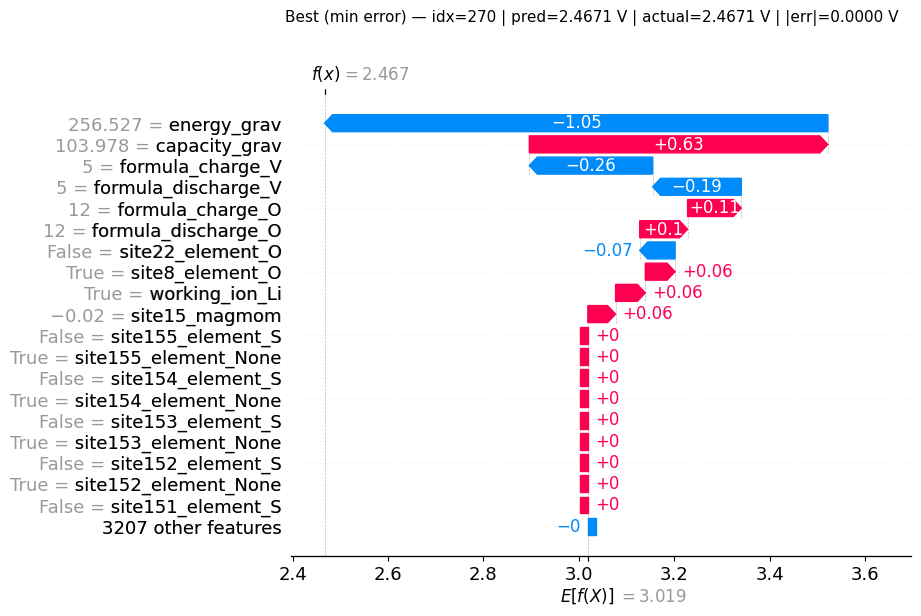

  0%|          | 0/1 [00:00<?, ?it/s]

Saved: shap_local_Median_(typical_error)_idx74.png


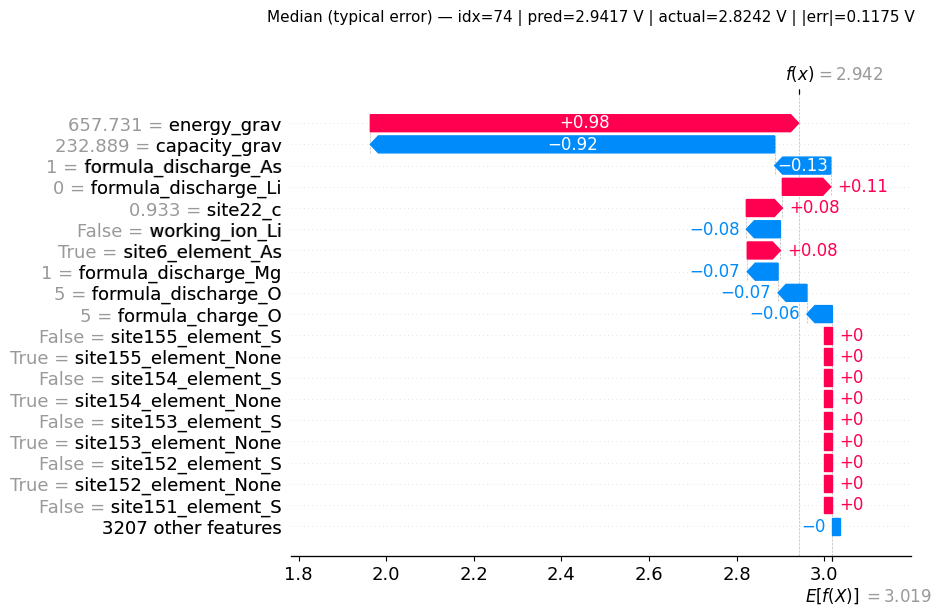

  0%|          | 0/1 [00:00<?, ?it/s]

Saved: shap_local_Worst_(max_error)_idx154.png


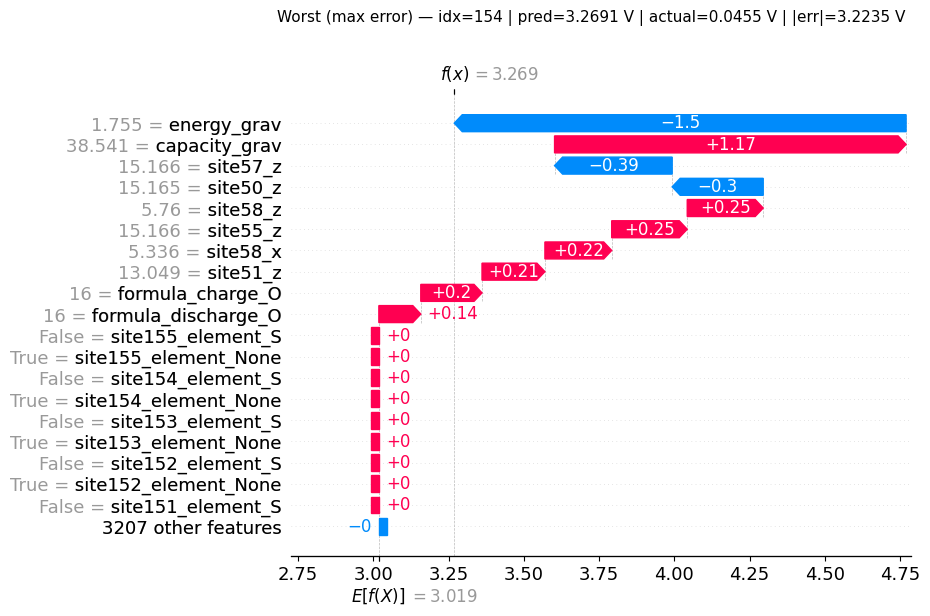

In [26]:
# 4) Generate the three local explanations
for label, i in triplet:
    explain_and_plot_idx(i, title_prefix=label)